## Imports

In [4]:
# data analysis
import pandas as pd
import numpy as np
# viz
import matplotlib.pyplot as plt
import seaborn as sns
# gensim models
import gensim
from gensim import matutils, utils
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaModel, TfidfModel
from gensim.models.basemodel import BaseTopicModel
from gensim.models.nmf import Nmf
# dimensionality reduction
import umap
from sklearn.decomposition import NMF
# clustering
import hdbscan
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors
# metric
from sklearn.metrics import silhouette_score
# data split
from sklearn.model_selection import train_test_split
# document vectorization
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# progress-bar
from tqdm.notebook import tqdm
# bert pretrained-models
from sentence_transformers import SentenceTransformer
# text proccessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
sws = stopwords.words('english')
sws.extend(['url', 'com', 'http', 'https', 'support', 'pack', 'edition', 
            'account', 'privacy', 'policy', 'download', 'game', 'window',
            'mac', 'linux', 'bit', 'early', 'access', 'system', 'th'])
from string import punctuation
# tools
from functools import lru_cache
from operator import itemgetter
from collections import defaultdict, Counter
import re
import warnings
warnings.filterwarnings('ignore')

In [12]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 800)

## EDA 

In [198]:
data = pd.read_csv('apps2.csv', na_values= '-')

In [199]:
data.drop(['Unnamed: 0'], axis=1, inplace=True)

In [338]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46595 entries, 0 to 46594
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             46595 non-null  object 
 1   Genre             46543 non-null  object 
 2   Developer         46508 non-null  object 
 3   Publisher         46312 non-null  object 
 4   Release           46380 non-null  object 
 5   Franchise         8887 non-null   object 
 6   Description       46595 non-null  object 
 7   Full Description  46595 non-null  object 
 8   Mature Content    5980 non-null   object 
 9   Tags              46595 non-null  object 
 10  Recent Score      3983 non-null   float64
 11  Scores            24703 non-null  float64
 12  Mean score        24703 non-null  float64
 13  URL               46595 non-null  object 
 14  Scores Count      25848 non-null  float64
 15  isFree            46595 non-null  object 
 16  use_cluster       46595 non-null  int32 

In [202]:
data.dropna(subset=['Full Description'], inplace=True)

## Тэги 

In [201]:
data[data['Tags'].isna()][:20] # нет тегов у каких-то комплементарных приложений, так что можно убрать эти строки
data.dropna(subset=['Tags'], inplace=True)

In [ ]:
data['Tags'] = data['Tags'].apply(lambda x: x.split(','))
data['Tags'] = data['Tags'].apply(lambda x: [tag.strip() for tag in x])

In [341]:
plt.rcParams.update(plt.rcParamsDefault)

In [53]:
def plot_top_words(model, feature_names, n_top_words, title, name):
    plt.rcParams.update(plt.rcParamsDefault)
    fig, axes = plt.subplots(3, 6, figsize=(30, 15)) # параметры отображения
    axes = axes.flatten()
    all_features = {} # словарь для сохранения ключевых слов для тем
    
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1] 
        top_features = [feature_names[i] for i in top_features_ind]
        # строка для сохранения темы и слов в словарь
        
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.savefig(name)
    plt.show()

## Подготовка описания

In [213]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [214]:
pattern = re.compile('[A-Za-z]+')

In [208]:
def remove_urls(raw_text):
    return re.sub(r'https?://[\w./?=-]+|www\.[\w./?=-]+', ' ', raw_text)

In [209]:
# функция, возвращающая список токенов с сохранением пунктуации внутри слов
def get_tokens(text):
    tokens = pattern.findall(text)
    clean_tokens = [word.lower() for word in tokens if word]
    return clean_tokens 

In [210]:
@lru_cache(maxsize=128)
def lemmatize_word(word):
    return lemmatizer.lemmatize(word, get_wordnet_pos(word))

def lemmatize_text(tokens):
    return [lemmatize_word(w) for w in tokens]

In [211]:
def remove_stopwords(lemmas, stopwords=sws):
    return [w for w in lemmas if not w in stopwords and len(w) > 1]

In [212]:
def preprocess(text):
    tokens = get_tokens(remove_urls(text))
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [215]:
tags = list(tqdm(map(preprocess, data['Tags']), total=len(data['Tags'])))

In [216]:
# краткое описание
lemmas = list(tqdm(map(preprocess, data['Description']), total=len(data['Description'])))
# полное описание
lemmas2 = list(tqdm(map(preprocess, data['Full Description']), total=len(data['Full Description'])))

In [237]:
prep_data = pd.DataFrame()
prep_data['Title'] = data['Title']
prep_data['Short desc'] = lemmas
prep_data['Full desc'] = lemmas2
prep_data['Tags'] = tags

In [240]:
# меняем пустые описания на nan
prep_data['Short desc'] = prep_data['Short desc'].apply(lambda x: x if not re.fullmatch('', x) else np.nan)

In [248]:
# меняем описание одним словом на nan
prep_data['Short desc'] = prep_data['Short desc'].apply(lambda x: x if not x.isalpha() else np.nan)

In [259]:
prep_data['Full desc'] = prep_data['Full desc'].apply(lambda x: x if not x.isalpha() else np.nan)

In [264]:
# убираем пустые описания
prep_data.dropna(subset=['Short desc', 'Full desc'], inplace=True)

In [265]:
prep_data.reset_index(inplace=True, drop=True)

In [271]:
prep_data['Short + Tags'] = prep_data[['Short desc', 'Tags']].apply(
    lambda x: ' '.join(x), axis=1)

In [309]:
prep_data.drop_duplicates(subset=['Title', 'Short + Tags'], inplace=True, keep='first')

In [311]:
prep_data['Text'] = prep_data[prep_data.columns[1:4]].apply(
    lambda x: ' '.join(x), axis=1)

In [281]:
# отдельный датафрейм с коротким описанием + теги
short_tags = pd.DataFrame()
short_tags[['Title', 'Text']] = prep_data[['Title', 'Short + Tags']]

short_tags.drop_duplicates(inplace=True, keep='first')

short_tags.reset_index(inplace=True, drop=True)

In [312]:
# отдельный датафрейм с полным описанием + теги
full_text = pd.DataFrame()
full_text[['Title', 'Text']] = prep_data[['Title', 'Text']]
indexing = [len(elem.split()) < 1000 for elem in prep_data['Text']]
# full_text = full_text[indexing]

# full_text.drop_duplicates(inplace=True, keep='first')
# full_text.reset_index(inplace=True, drop=True)

In [73]:
short_tags.to_csv('short_tags.csv')
full_text.to_csv('short_full_tags.csv')

In [6]:
word_count = [len(elem.split()) for elem in short['Text']]
word_count_full = [len(elem.split()) for elem in full['Text']]

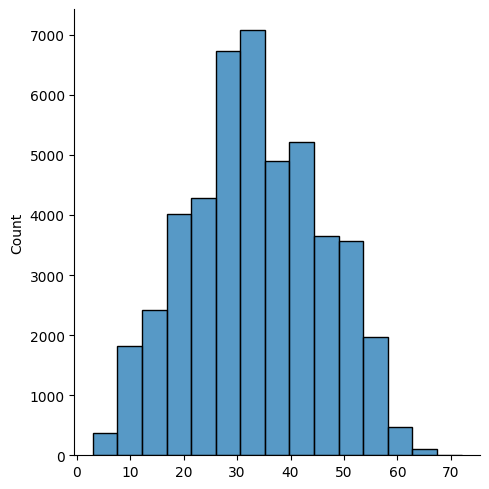

In [344]:
sns.displot(word_count, bins=15)
plt.savefig('plot1.png')
plt.show()

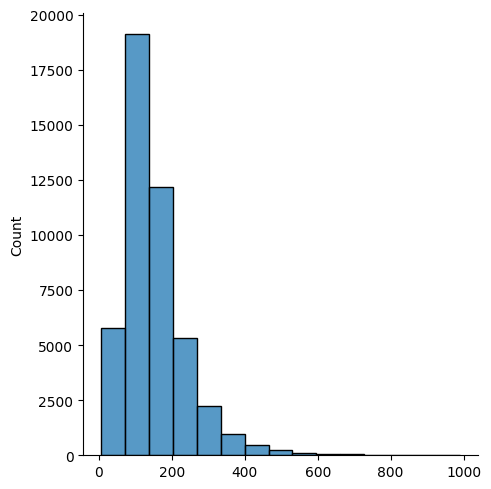

In [345]:
sns.displot(word_count_full, bins=15)

plt.savefig('plot2.png')
plt.show()

## TF-IDF + NMF 

In [5]:
full = pd.read_csv('short_full_tags.csv')
short = pd.read_csv('short_tags.csv')

In [ ]:
# уровень согласованности топика
# Use Gensim's NMF to get the best num of topics via coherence score
texts = full['Text'].str.split()

# Create a dictionary
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=10000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(10, 40 + 1))

# Run the nmf model and calculate the coherence score for each number of topics
coherence_scores = []

for num in tqdm(topic_nums, total=len(topic_nums)):
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

In [ ]:
sorted(scores, key=itemgetter(1), reverse=True)

[(27, 0.47831),
 (32, 0.47365),
 (18, 0.47356),
 (31, 0.47279),
 (26, 0.47125),
 (33, 0.46643),
 (35, 0.46468),
 (22, 0.46412),
 (14, 0.46123),
 (15, 0.46087),
 (24, 0.46084),
 (34, 0.46084),
 (39, 0.45996),
 (25, 0.4589),
 (40, 0.45776),
 (8, 0.45745),
 (23, 0.45525),
 (28, 0.45489),
 (19, 0.45475),
 (5, 0.45407),
 (13, 0.45394),
 (30, 0.45294),
 (38, 0.45261),
 (37, 0.45154),
 (16, 0.45129),
 (29, 0.45019),
 (36, 0.4497),
 (21, 0.44585),
 (17, 0.44271),
 (11, 0.44263),
 (20, 0.43804),
 (10, 0.43736),
 (12, 0.42793),
 (7, 0.42519),
 (9, 0.42096),
 (6, 0.41543)]

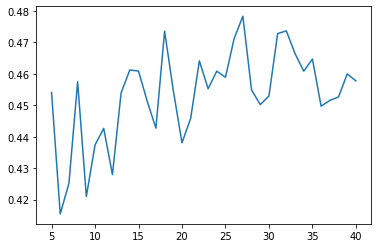

In [ ]:
fig, ax = plt.subplots()
ax.plot(topic_nums, coherence_scores)
plt.xlabel('Количество топиков')
plt.ylabel('Coherence score')
plt.show()

Оптимальное количество топиков - 14(для короткого описания + теги), 27 - для полного описания.

In [46]:
vectorizer = TfidfVectorizer(min_df=10, 
                             max_df=0.80, 
                             ngram_range=(1, 2), 
                             max_features=10000)

In [47]:
description_matrix = vectorizer.fit_transform(full['Text'])

In [48]:
desc_feature_names = vectorizer.get_feature_names()

In [49]:
nmf = NMF(n_components=18, random_state=42)

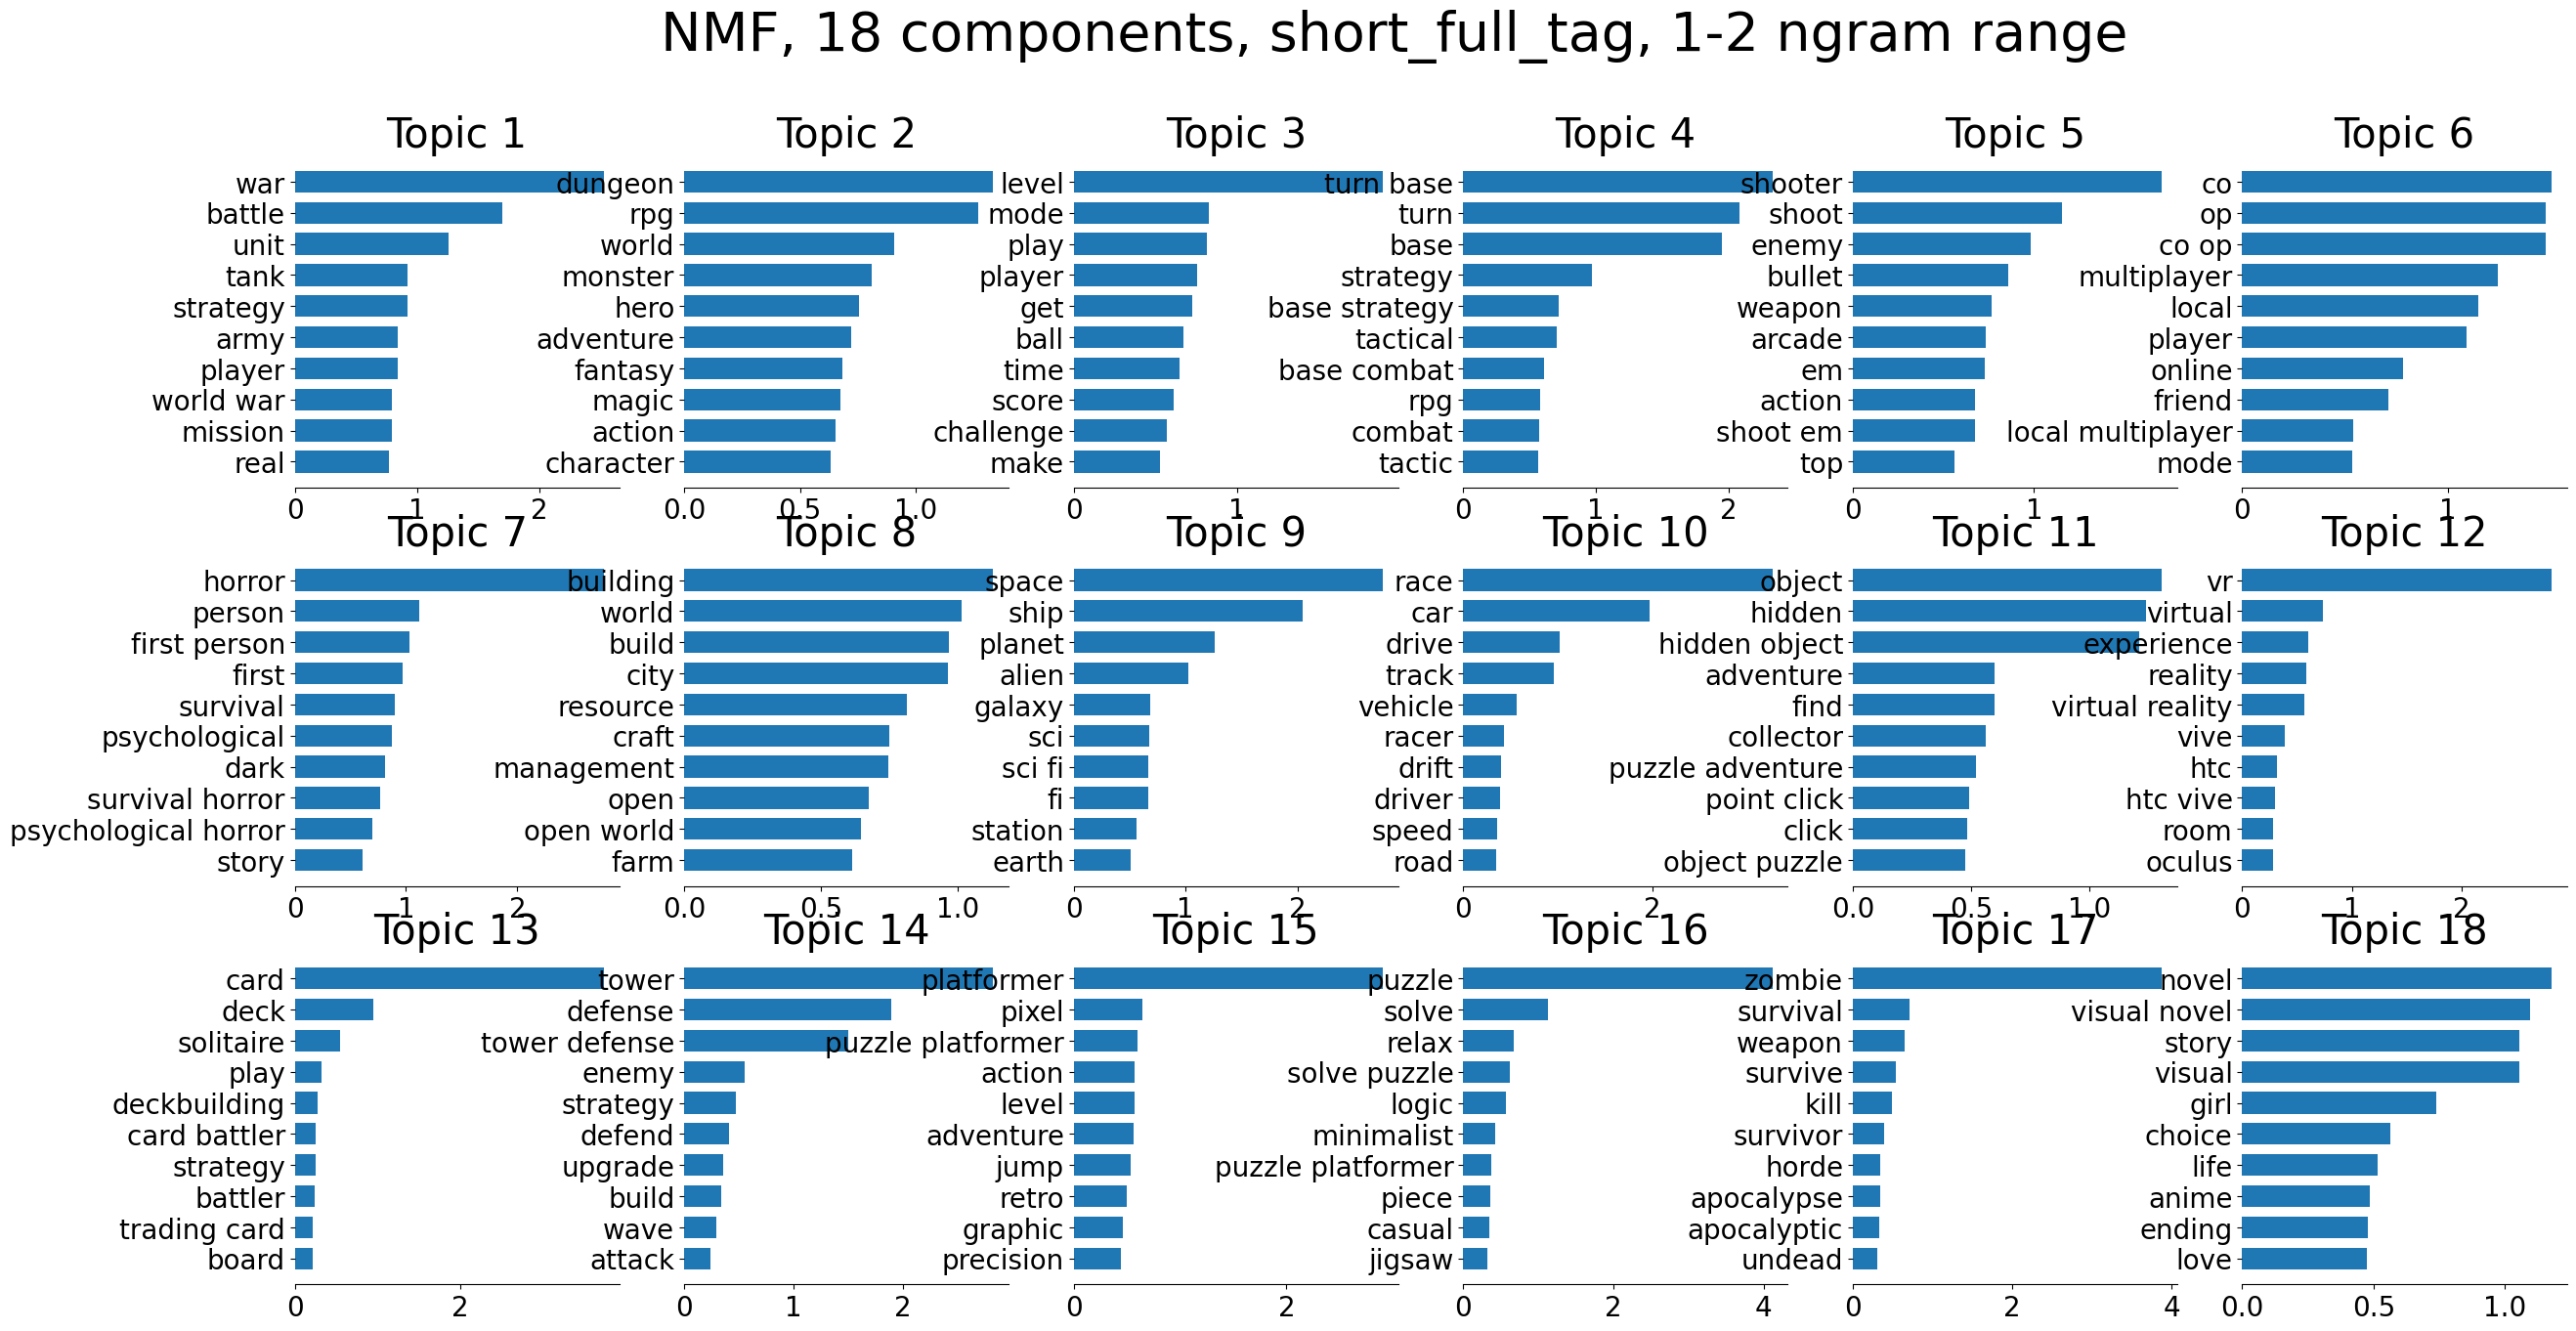

In [58]:
# nmf.fit(description_matrix)
plot_top_words(nmf, desc_feature_names, 10, 'NMF, 18 components, short_full_tag, 1-2 ngram range', 'topics.png')

In [68]:
top = {1: 'War', 2: 'RPG', 3: 'Sport', 
       4: 'Strategy/turn-base', 5: 'Shooter', 6: 'Multiplayer', 
       7: 'Horror/Survival', 8: 'Building', 9: 'Space', 
       10: 'Race', 11: 'Hidden objects', 12: 'VR', 
       13: 'Cards', 14: 'Tower Defense', 15: 'Platformer', 
       16: 'Puzzle', 17: 'Zombie/Survival', 18: 'Novel/ Story'}

In [69]:
nmf_res = nmf.transform(description_matrix)

In [70]:
topic = [doc.argmax()+ 1 for doc in nmf_res]

In [204]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46595 entries, 0 to 46594
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      46595 non-null  int64 
 1   Title           46595 non-null  object
 2   Text            46595 non-null  object
 3   topic           46595 non-null  object
 4   Cluster_tf-idf  46595 non-null  int32 
 5   cluster_umap    46595 non-null  int32 
dtypes: int32(2), int64(1), object(3)
memory usage: 1.8+ MB


In [71]:
full['topic'] = [top[i] for i in topic]
full[:20]

,Unnamed: 0,Title,Text,topic
0,0,Counter-Strike: Global Offensive,counter strike global offensive go expands upo...,Multiplayer
1,1,Apex Legends™,apex legend award win free play hero shooter r...,RPG
2,2,Dead by Daylight,dead daylight multiplayer horror one player ta...,Horror/Survival
3,3,Warframe,warframe cooperative free play third person on...,Multiplayer
4,4,Grand Theft Auto V,grand theft auto pc offer player option explor...,Multiplayer
5,5,Tom Clancy's Rainbow Six® Siege,tom clancy rainbow six siege late installment ...,Multiplayer
6,6,Phantasy Star Online 2 New Genesis,phantasy star online new genesis late chapter ...,Multiplayer
7,7,PLAYERUNKNOWN'S BATTLEGROUNDS,playerunknown battleground battle royale shoot...,Multiplayer
8,8,Monster Hunter: World,welcome new world monster hunter world late in...,RPG
9,9,It Takes Two,embark craziest journey life take two invite f...,Multiplayer


In [65]:
count = defaultdict(int)
for elem in nmf_res:
    count[elem.argmax() + 1] += 1

df_count = pd.DataFrame(count.items(), columns=['Topic', 'Count'])

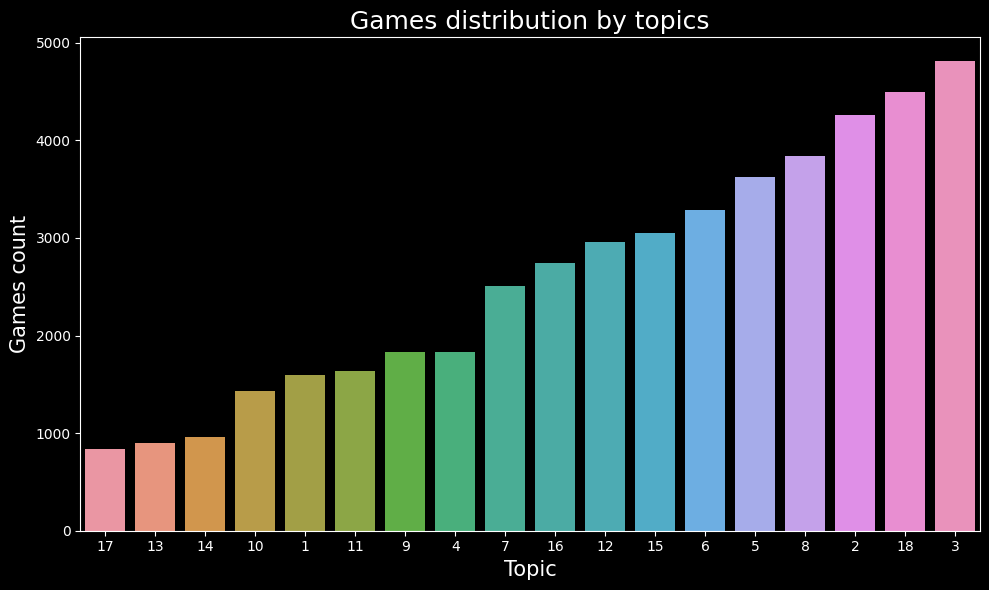

In [72]:
plt.figure(figsize=(10,6))
# make barplot and sort bars
sns.barplot(x="Topic", 
            y='Count', 
            data=df_count, 
            order=df_count.sort_values('Count').Topic) 
# set labels
plt.xlabel("Topic", size=15)
plt.ylabel("Games count", size=15)
plt.title("Games distribution by topics", size=18)
plt.tight_layout()

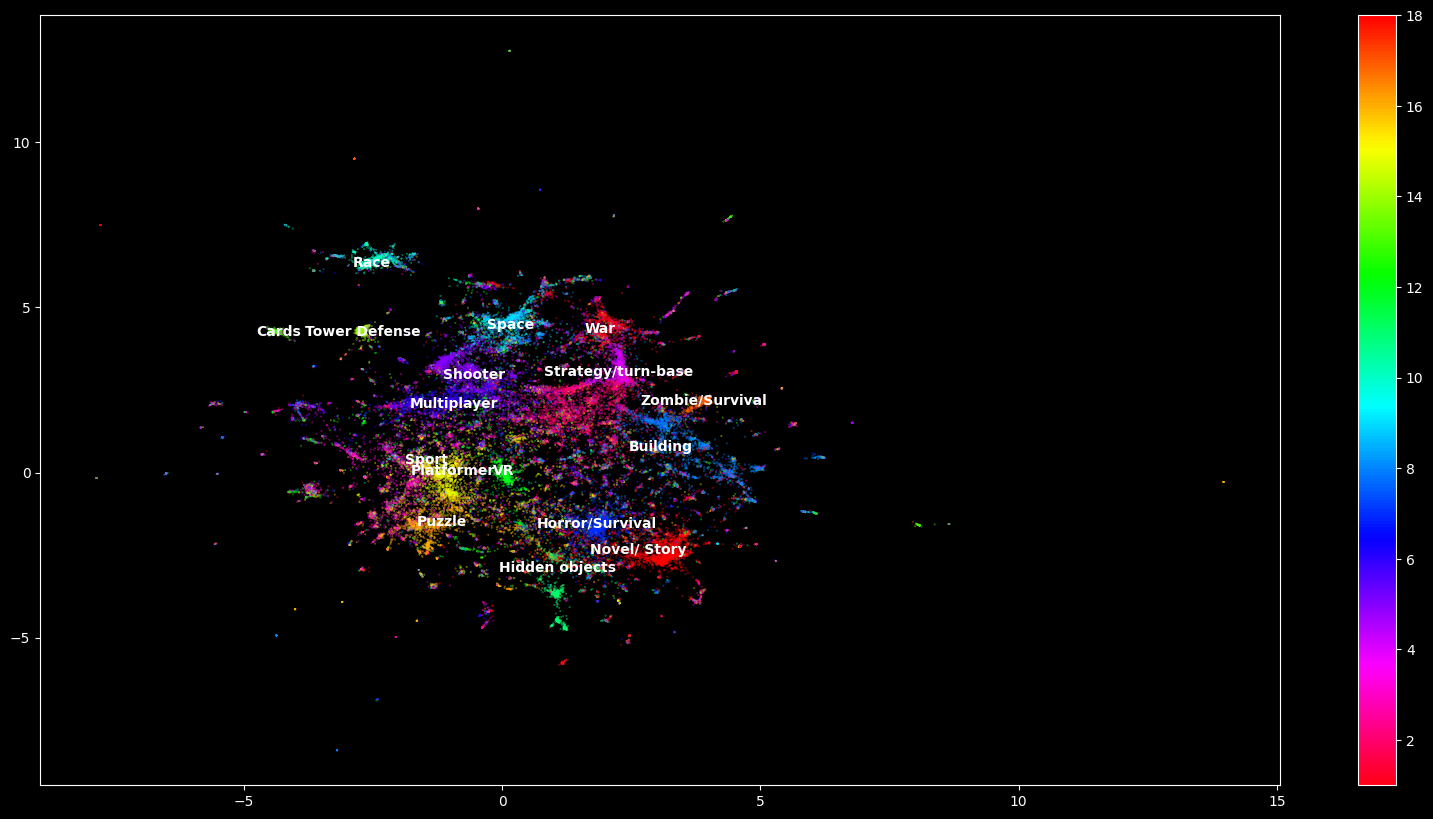

In [67]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(description_matrix)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = full['topic'].to_list()

# Visualize clusters
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(20, 10))
clustered = result.loc[result.labels != -1, :]
plt.scatter(clustered.x, clustered.y, c=topic, s=0.05, cmap='hsv_r')

for label in top.values():
    plt.annotate(label, 
                 result.loc[result['labels']==label,['x','y']].median(),
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=10, weight='bold') 
plt.colorbar()
plt.savefig('plot_topics.png')
plt.show()

In [52]:
silhouette = {}
inertia = []
for i in tqdm(range(100,201, 25)):
    kmeans = KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(nmf_res)
    inertia.append(kmeans.inertia_)
    silhouette[i] = silhouette_score(nmf_res, kmeans.labels_, metric='euclidean')

print(silhouette)
print(inertia)


{100: 0.13289550209676496, 125: 0.12782856247795626, 150: 0.1244530610643502, 175: 0.1248350289754098, 200: 0.119109747300162}
[28.57655239261661, 26.53568306625417, 24.977967360370634, 23.801982024260926, 22.833672233866825]


In [130]:
def viz_metrics(inertia, silhouette, x, y, z):
    plt.rcParams.update(plt.rcParamsDefault)
    sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

    plt.subplot(1, 2, 1) # аргументы: nrows, ncols, index
    
    plt.plot(range(x, y, z), inertia, marker='x',color='blue') 
    # первый параметр = x (число шагов= числу кластеров), второй = y (инерция)
    
    plt.xlabel('Число кластеров')
    plt.title('K-means Inertia',fontweight='bold')
    plt.grid(True)
    
    plt.subplot(1, 2, 2) # аргументы: nrows, ncols, index
    
    plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'blue')
    plt.xticks(range(len(silhouette)), list(silhouette.keys())) # отметки на шкале
    plt.grid(True)
    plt.title('Silhouette Score',fontweight='bold')
    plt.xlabel('Число кластеров')
    plt.savefig('metrics.png')
    
    plt.show()

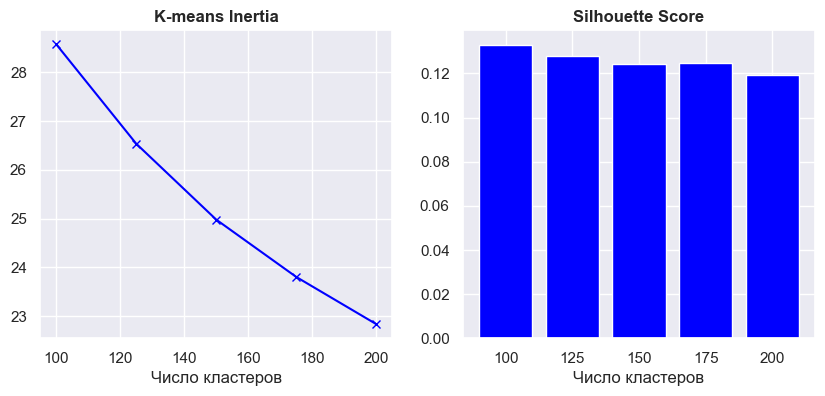

In [56]:
viz_metrics(inertia, silhouette, 100, 201, 25)

In [73]:
kmeans = KMeans(n_clusters=125,
           init='k-means++',
           n_init=15,
           max_iter=500,
           random_state=17)
kmeans.fit(nmf_res)

KMeans(max_iter=500, n_clusters=125, n_init=15, random_state=17)

In [74]:
Counter(kmeans.labels_).most_common()

[(106, 1212),
 (1, 1146),
 (37, 1075),
 (48, 924),
 (109, 917),
 (61, 912),
 (123, 908),
 (2, 882),
 (51, 835),
 (73, 830),
 (29, 801),
 (63, 752),
 (124, 738),
 (57, 737),
 (66, 722),
 (120, 708),
 (79, 651),
 (27, 632),
 (4, 604),
 (25, 601),
 (28, 598),
 (95, 574),
 (56, 543),
 (46, 539),
 (94, 526),
 (24, 522),
 (99, 518),
 (90, 494),
 (38, 493),
 (50, 484),
 (83, 483),
 (31, 483),
 (116, 471),
 (36, 470),
 (13, 469),
 (101, 468),
 (19, 454),
 (5, 448),
 (53, 445),
 (117, 444),
 (98, 440),
 (3, 437),
 (105, 423),
 (16, 422),
 (55, 421),
 (93, 418),
 (23, 414),
 (32, 392),
 (52, 388),
 (82, 376),
 (33, 373),
 (108, 359),
 (6, 350),
 (85, 346),
 (71, 343),
 (30, 334),
 (43, 321),
 (70, 315),
 (26, 314),
 (80, 312),
 (62, 308),
 (68, 304),
 (119, 303),
 (111, 295),
 (75, 294),
 (8, 293),
 (20, 284),
 (49, 279),
 (114, 275),
 (0, 271),
 (15, 270),
 (104, 269),
 (69, 265),
 (88, 261),
 (64, 261),
 (60, 246),
 (65, 241),
 (35, 238),
 (12, 235),
 (110, 233),
 (18, 230),
 (115, 230),
 (22,

In [168]:
# full['Cluster_tf-idf'] = kmeans.labels_
full[full['Cluster_tf-idf'] == 1]

,Unnamed: 0,Title,Text,topic,Cluster_tf-idf,cluster_umap
33,33,Slime Rancher,slime rancher tale beatrix lebeau plucky young...,Building,1,184
46,46,The Sims™ 4,play life discover possibility unleash imagina...,Building,1,161
150,150,Two Point Hospital,design stun hospital cure peculiar illness man...,Building,1,122
169,169,Legends of IdleOn - Idle MMO,create multiple character work together go spe...,Building,1,59
237,237,Cooking Simulator,play one best cooking take control highly poli...,Building,1,9
...,...,...,...,...,...,...
46463,46463,Project Prison,ever thought best place start criminal empire ...,Building,1,107
46487,46487,Dolphin Trainer VR,become dolphin trainer start training complete...,Building,1,65
46581,46581,Airport Renovator,start new adventure restore airport bring reno...,Building,1,123
46593,46593,Cooking Simulator VR,become ultimate chef vr take control highly po...,Building,1,9


In [18]:
def cl_viz(data, labels, name):
    umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(data)
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    result['labels'] = labels
    
    plt.rcParams.update(plt.rcParamsDefault)
    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(20, 10))
    outliers = result.loc[result.labels == -1, :]
    clustered = result.loc[result.labels != -1, :]
    plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
    plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
    plt.colorbar()
    plt.savefig(name)
    plt.show()

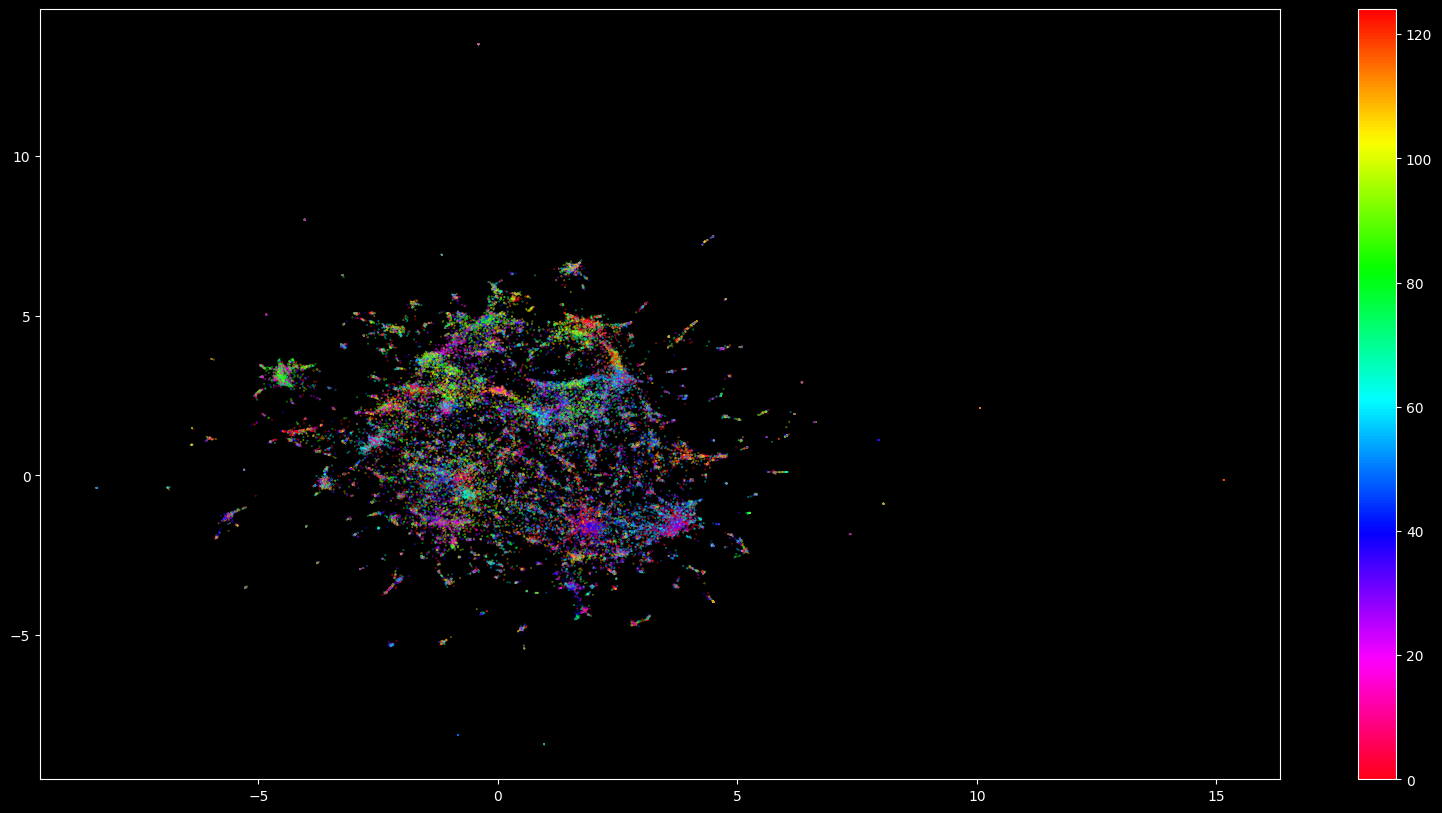

In [96]:
cl_viz(description_matrix, kmeans.labels_, 'cl.png')

### Вывод по tf-idf + nmf : хорошие топики, кластеризуется только по Kmeans, DBSCAN не работает.

## TF-IDF + UMAP

In [15]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(description_matrix)

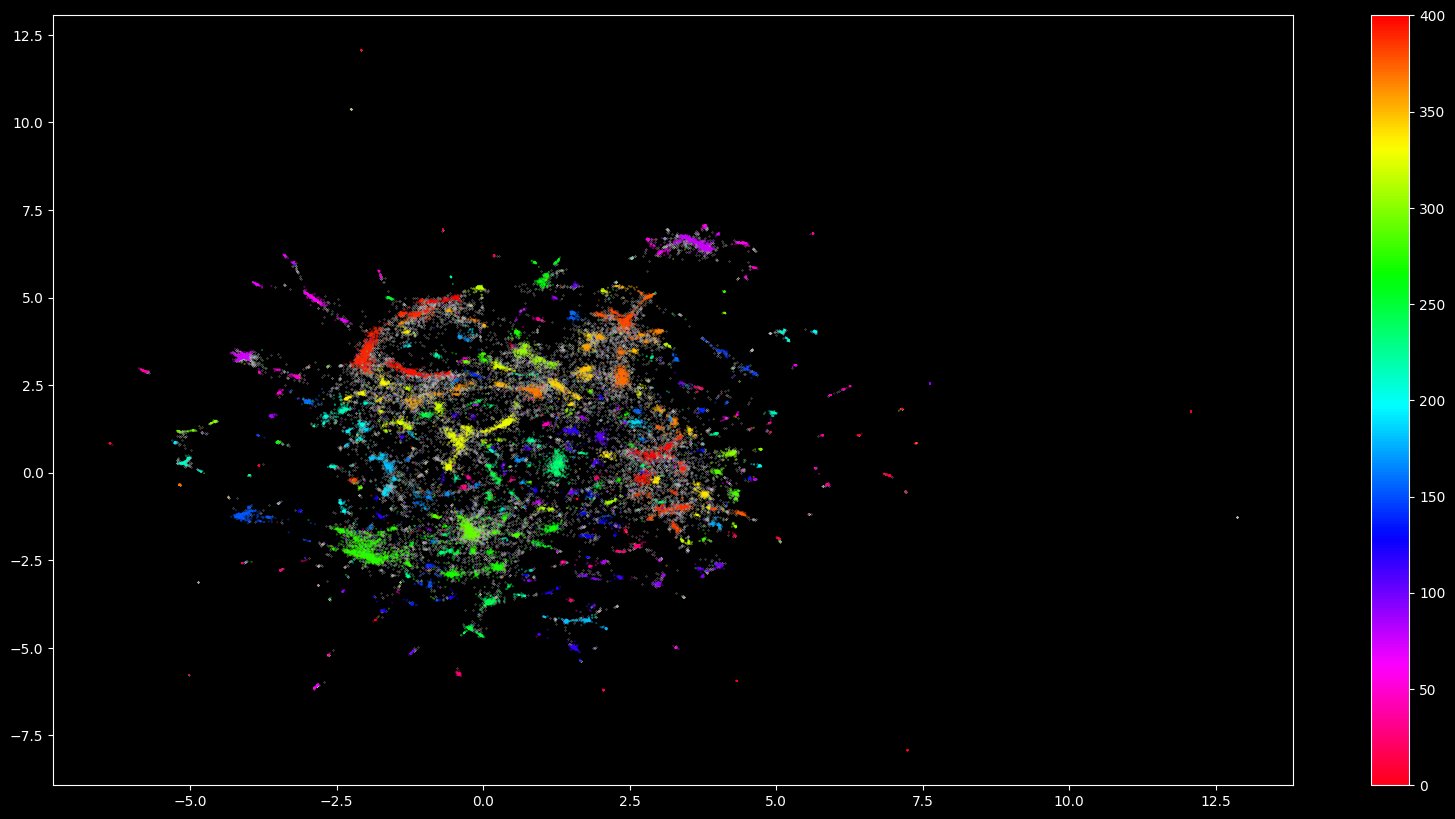

In [19]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15).fit(umap_embeddings)

print(Counter(cluster.labels_).most_common())

print(silhouette_score(umap_embeddings, cluster.labels_))

cl_viz(description_matrix, cluster.labels_, 'plot_hdbscan_umap_tfidf.png')

In [100]:
docs_df = pd.DataFrame(full, columns=["Text"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Text': ' '.join})

In [101]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

In [102]:
tf_idf, count = c_tf_idf(docs_per_topic.Text.values, m=len(full))
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

In [108]:
def get_eps(matrix):
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(matrix)
    distances, indices = nbrs.kneighbors(matrix)
    
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.show()

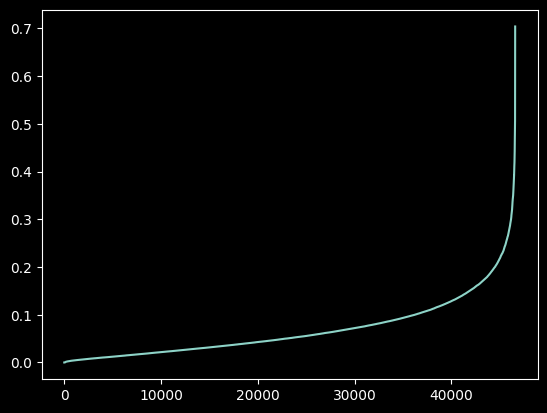

In [109]:
get_eps(umap_embeddings)

In [112]:
cluster.labels_

array([ -1, 271, 253, ..., 390, 180, 190])

In [132]:
# cluster2 = DBSCAN(min_samples=15, eps=0.18).fit(umap_embeddings)

print(silhouette_score(umap_embeddings, cluster2.labels_))

# print(Counter(cluster2.labels_).most_common())

# cl_viz(description_matrix, cluster2.labels_, 'cl.png')

0.07264558


In [117]:
docs_df = pd.DataFrame(full, columns=["Text"])
docs_df['Topic'] = cluster2.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Text': ' '.join})

In [118]:
tf_idf, count = c_tf_idf(docs_per_topic.Text.values, m=len(full))

In [119]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

In [120]:
top_n_words[11]

[('dungeon', 0.014227696356645402),
 ('unit', 0.011204630807352397),
 ('turn', 0.011108374033572977),
 ('war', 0.010119481875303725),
 ('tactical', 0.008878206485816019),
 ('rpg', 0.0075826991044013045),
 ('combat', 0.007289161194159705),
 ('strategy', 0.00709710000342402),
 ('base', 0.006985082311068584),
 ('tactic', 0.006885842317291284),
 ('roguelike', 0.006568569991823837),
 ('battle', 0.006437893201923431),
 ('army', 0.006388651116311365),
 ('crawler', 0.0056538309369112),
 ('campaign', 0.005636530498582365),
 ('fantasy', 0.005199850095323697),
 ('party', 0.005123845870947186),
 ('map', 0.004742891972437682),
 ('generate', 0.00456060516116625),
 ('ii', 0.004525056700830622)]

In [121]:
for i in tqdm(range(100,201, 25)):
    kmeans = KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(umap_embeddings)
    inertia.append(kmeans.inertia_)
    silhouette[i] = silhouette_score(umap_embeddings, kmeans.labels_, metric='euclidean')

print(silhouette)
print(inertia)


{100: 0.3822172, 125: 0.39638197, 150: 0.40268567, 175: 0.4186395, 200: 0.4206765}
[28.57655239261661, 26.53568306625417, 24.977967360370634, 23.801982024260926, 22.833672233866825, 15640.0615234375, 12700.3525390625, 10550.0341796875, 8957.8232421875, 7826.16455078125]


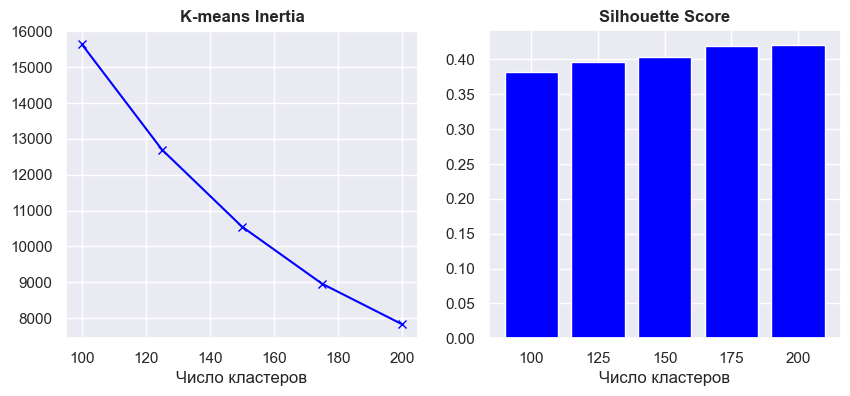

In [131]:
viz_metrics(inertia[5:], silhouette, 100, 201, 25)

In [127]:
kmeans = KMeans(n_clusters=200,
           init='k-means++',
           n_init=15,
           max_iter=500,
           random_state=17)
kmeans.fit(umap_embeddings)

KMeans(max_iter=500, n_clusters=200, n_init=15, random_state=17)

In [128]:
print(Counter(kmeans.labels_).most_common())

[(84, 776), (17, 686), (128, 685), (10, 677), (12, 672), (56, 618), (63, 606), (159, 605), (25, 591), (30, 581), (141, 575), (51, 541), (32, 541), (67, 531), (100, 525), (105, 523), (8, 509), (137, 492), (20, 488), (169, 487), (64, 478), (60, 473), (5, 465), (22, 459), (7, 456), (53, 451), (91, 438), (170, 434), (92, 430), (154, 410), (93, 394), (124, 389), (152, 383), (11, 377), (29, 375), (75, 372), (193, 357), (143, 357), (140, 345), (188, 344), (6, 338), (21, 338), (71, 337), (102, 334), (59, 331), (88, 331), (2, 327), (18, 324), (191, 319), (97, 319), (112, 318), (85, 310), (33, 307), (109, 306), (48, 302), (15, 300), (121, 295), (83, 290), (49, 289), (9, 275), (172, 273), (45, 270), (19, 268), (113, 266), (47, 265), (108, 258), (111, 258), (66, 258), (26, 257), (0, 256), (37, 254), (39, 253), (139, 252), (27, 252), (24, 249), (142, 248), (16, 248), (77, 245), (184, 244), (153, 240), (131, 239), (52, 238), (95, 237), (23, 234), (156, 229), (58, 228), (94, 224), (130, 223), (187, 2

In [173]:
# full['cluster_umap'] = kmeans.labels_
full[full['cluster_umap'] == 141][:20]

,Unnamed: 0,Title,Text,topic,Cluster_tf-idf,cluster_umap
269,269,Kinkoi: Golden Loveriche,kinkoi golden loveriche japanese style visual ...,Novel/ Story,31,141
344,344,NEKOPARA Vol. 1,nekopara cat paradise kashou minaduki son long...,Novel/ Story,2,141
367,367,Table Manners: Physics-Based Dating Game,swipe right brand new non vr crazy physic base...,Novel/ Story,48,141
370,370,NEKOPARA Vol. 4,despite popularity la soleil kashou father con...,Novel/ Story,2,141
375,375,VR Kanojo / VRカノジョ,steam version character trial version steam ve...,VR,63,141
422,422,NEKOPARA Vol. 3,patisserie la soleil run kashou minaduki flour...,Novel/ Story,2,141
501,501,Senren＊Banka,senren banka japanese style visual novel produ...,Novel/ Story,31,141
541,541,OshiRabu: Waifus Over Husbandos,wanna marry simple word set motion yuri cat mo...,Novel/ Story,2,141
586,586,Summer~Life in the Countryside~,simulation reunite childhood friend spending s...,Novel/ Story,61,141
611,611,Love Esquire - RPG/Dating Sim/Visual Novel,usually play hero time lowly squire epic quest...,Novel/ Story,31,141


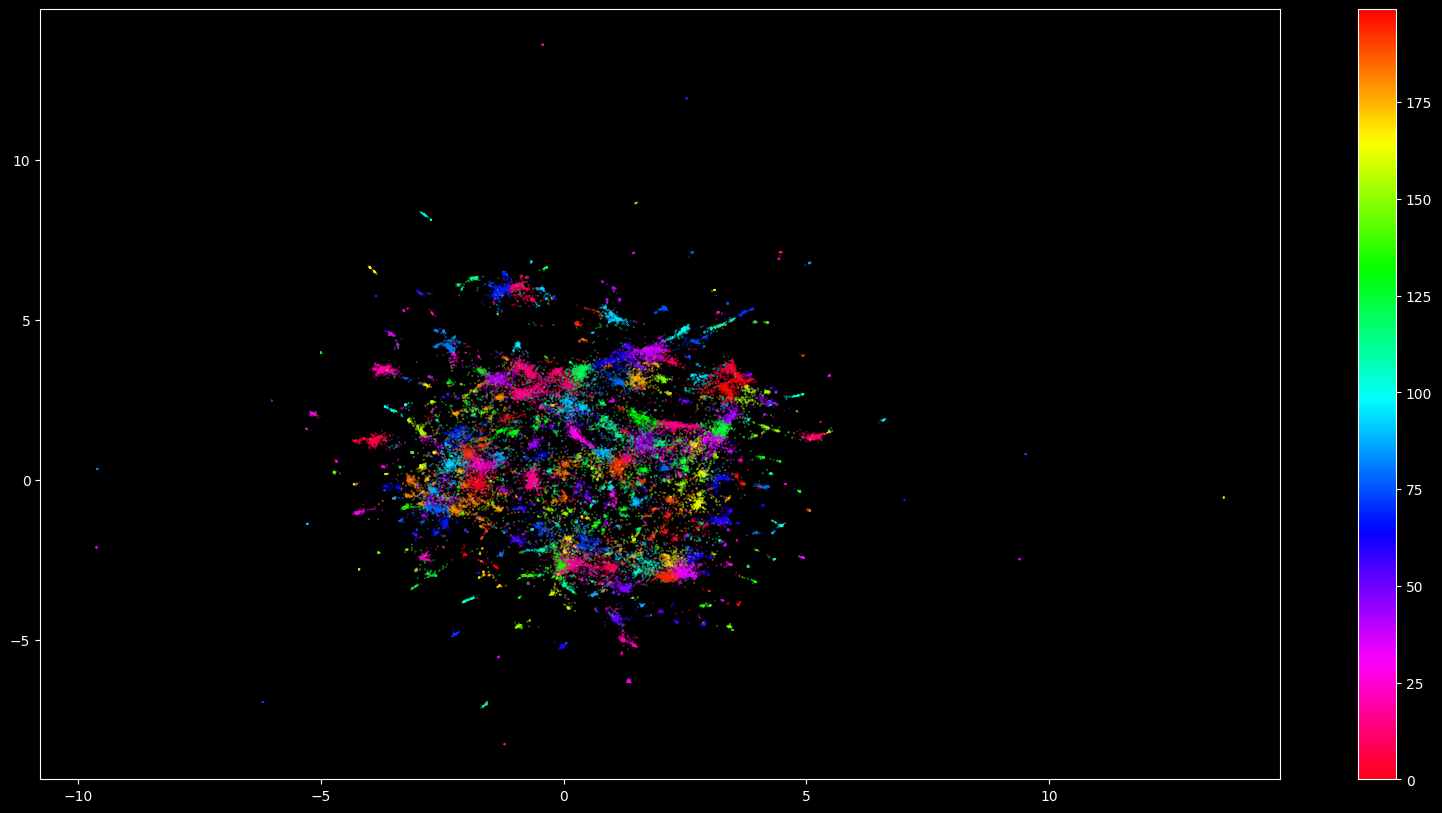

In [449]:
cl_viz(description_matrix, full['cluster_umap'])

#### TF-IDF + UMAP - выше метрики и по DBSCAN, и по Kmeans, но кажется, что кластеры получились лучше с nmf.

## Doc2Vec

In [342]:
X_train, X_test = train_test_split(short['Text'], test_size=0.1, random_state=42)

In [399]:
def read_corpus(f, tokens_only=False):
        for i, line in enumerate(f):
            tokens = line.split()
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_corpus = list(read_corpus(short['Text']))
test_corpus = list(read_corpus(X_test, tokens_only=True))

In [400]:
print(train_corpus[:2])

[TaggedDocument(words=['counter', 'strike', 'global', 'offensive', 'go', 'expands', 'upon', 'team', 'base', 'action', 'gameplay', 'pioneer', 'launch', 'year', 'ago', 'go', 'feature', 'new', 'map', 'character', 'weapon', 'mode', 'delivers', 'update', 'version', 'classic', 'content', 'de_dust', 'etc', 'fps', 'shooter', 'multiplayer', 'competitive', 'action', 'team', 'base', 'esports', 'tactical', 'first', 'person', 'pvp', 'online', 'co', 'op', 'co', 'op', 'strategy', 'military', 'war', 'difficult', 'trading', 'realistic', 'fast', 'pace', 'moddable'], tags=[0]), TaggedDocument(words=['experience', 'survival', 'horror', 'like', 'never', 'th', 'major', 'installment', 'resident', 'evil', 'franchise', 'resident', 'evil', 'village', 'detailed', 'graphic', 'intense', 'first', 'person', 'action', 'masterful', 'storytelling', 'terror', 'never', 'felt', 'realistic', 'survival', 'horror', 'first', 'person', 'horror', 'singleplayer', 'action', 'sexual', 'content', 'zombie', 'gore', 'atmospheric', 'v

In [345]:
print(test_corpus[:2])

[['red', 'spider', 'hong', 'kong', 'noir', 'theme', 'visual', 'novel', 'story', 'route', 'different', 'character', 'approximately', 'word', 'total', 'adventure', 'visual', 'novel'], ['star', 'campus', 'life', 'interest', 'let', 'experience', 'different', 'campus', 'life', 'campus', 'life', 'feel', 'different', 'atmosphere', 'different', 'story', 'let', 'step', 'step', 'explore', 'fun', 'indie', 'casual', 'strategy', 'rpg', 'simulation']]


In [401]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
# model.save("d2v.model")
# print("Model Saved")

In [336]:
# model= gensim.models.Doc2Vec.load("d2v.model")

In [402]:
model.dv = model.__dict__['docvecs']

In [404]:
matrix = list(tqdm(map(model.infer_vector, short['Text'].str.split()), total=len(short)))

In [405]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5,
                            min_dist=0.0,
                            metric='cosine').fit_transform(matrix)

In [412]:
inertia = []
silhouette = {}
for i in tqdm(range(100,201, 25)):
    kmeans = KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(umap_embeddings)
    inertia.append(kmeans.inertia_)
    silhouette[i] = silhouette_score(umap_embeddings, kmeans.labels_, metric='euclidean')

print(silhouette)
print(inertia)


{100: 0.24081264, 125: 0.23168409, 150: 0.22778334, 175: 0.22706713, 200: 0.22820365}
[8539.6865234375, 7555.525390625, 6848.40576171875, 6313.78564453125, 5878.67578125]


In [418]:
# short['cluster'] = kmeans.labels_
short[short['cluster'] == 6]

,Unnamed: 0,Title,Text,cluster
2095,2095,Tomb Raider I,adventurer lara croft hire recover piece ancient artifact know scion fearless acrobatic style run jump swim climb way towards truth origin power leave trail empty tomb gun cartridge wake adventure action classic female protagonist singleplayer puzzle platformer third person retro action adventure third person shooter old school platformer shooter atmospheric exploration dinosaur great soundtrack puzzle platformer,5
2657,2657,Disney•Pixar WALL-E,base computer animate film pixar animation studio video version wall involves play lonely robot navigates trash taint world begin unlikely trek across cosmos adventure robot space puzzle post apocalyptic multiplayer family friendly singleplayer action sci fi great soundtrack story rich third person psychological horror,5
2706,2706,Lucy -The Eternity She Wished For-,robot could laugh cry smile soul visual novel anime date sim story rich romance cute robot drama multiple ending singleplayer simulation indie great soundtrack choose adventure casual sci fi adventure science fantasy,5
3028,3028,Bug Academy,bug academy crazy action control swarm insect break wall deliver fridge send rocket space use chili sauce catch ghost vacuum cleaner finish lesson pas final exam become bug academy graduate casual indie funny singleplayer physic adventure puzzle puzzle platformer comedy platformer exploration cute colorful,5
3056,3056,Comet 64,comet program puzzle year get comet home computer operator manual come program puzzle simulation indie retro education difficult building sandbox hack automation logic type science singleplayer text base minimalist old school,5
...,...,...,...,...
44261,44261,Snake Man's Adventure,help snake man save earth maybe even whole galaxy unique platform adventure make new friend universe explore numerous environment find hidden secret watch enemy obstacle time prove snake hero platformer action adventure side scroller platformer indie colorful singleplayer retro dog cute anime comedy funny controller metroidvania superhero sci fi linear action,5
44663,44663,Gates of Mirnah,gate mirnah upcoming story driven sci fi action adventure energy base combat gate mirnah guarantee fun action variety action adventure puzzle sci fi action exploration female protagonist third person story rich stealth rhythm parkour atmospheric indie singleplayer thriller adventure logic philosophical alien dark,5
44810,44810,G for Gravity,cute take post apocalyptic earth shatter asteroid take role thrifty robot try save humankind discover different level collect item repair gravity device short atmospheric indie casual adventure puzzle exploration hidden object colorful cute third person atmospheric futuristic post apocalyptic relax robot character customization procedural generation tutorial singleplayer free play indie,5
45710,45710,Robot Rescue Revolution,dodge flamers breathing scorch fire deactivate paralyze tesla machine guide wacky robot trap treacherous labyrinth exit plan escape precision every single robot share link control hinder simple escape plan even creator indie casual puzzle robot,5


### Doc2Vec : dbscan не работает, Kmeans неудачно кластеризует. 

## Bert pre-trained

In [27]:
embedder = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [135]:
import pickle
with open('/Users/darapetruhnenko/Downloads/bert_emb.pickle', 'rb') as f:
    corpus_embeddings = pickle.load(f)

In [169]:
# corpus_embeddings = list(tqdm(map(embedder.encode, short['Text']), total=len(short)))

In [136]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5,
                            min_dist=0.0,
                            metric='cosine').fit_transform(corpus_embeddings)

In [137]:
inertia = []
silhouette = {}
for i in tqdm(range(100,201, 25)):
    kmeans = KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(umap_embeddings)
    inertia.append(kmeans.inertia_)
    silhouette[i] = silhouette_score(umap_embeddings, kmeans.labels_, metric='euclidean')

print(silhouette)
print(inertia)


{100: 0.28880697, 125: 0.27062994, 150: 0.27930206, 175: 0.27700263, 200: 0.27701667}
[8525.7529296875, 7357.0986328125, 6487.36962890625, 5846.67236328125, 5353.837890625]


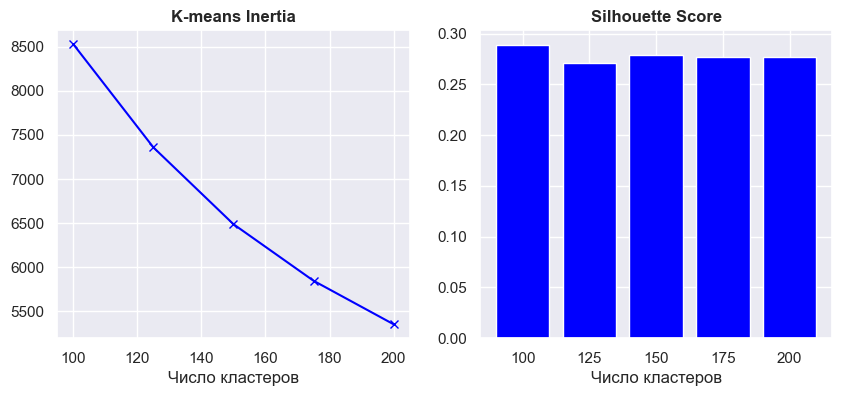

In [138]:
viz_metrics(inertia, silhouette, 100, 201, 25)

In [139]:
kmeans = KMeans(n_clusters=100,
           init='k-means++',
           n_init=15,
           max_iter=500,
           random_state=17)
kmeans.fit(umap_embeddings)

KMeans(max_iter=500, n_clusters=100, n_init=15, random_state=17)

In [144]:
Counter(kmeans.labels_).most_common()

[(14, 1119),
 (65, 1082),
 (83, 1071),
 (53, 1015),
 (26, 957),
 (43, 892),
 (6, 844),
 (54, 833),
 (93, 817),
 (22, 813),
 (46, 789),
 (60, 778),
 (33, 752),
 (5, 707),
 (61, 701),
 (41, 697),
 (4, 692),
 (95, 689),
 (39, 674),
 (52, 659),
 (98, 641),
 (13, 640),
 (10, 632),
 (11, 624),
 (21, 624),
 (88, 620),
 (86, 612),
 (20, 606),
 (25, 592),
 (38, 591),
 (28, 586),
 (68, 571),
 (31, 563),
 (81, 559),
 (12, 558),
 (47, 554),
 (94, 554),
 (64, 548),
 (0, 544),
 (3, 538),
 (36, 528),
 (74, 523),
 (18, 520),
 (7, 520),
 (55, 516),
 (17, 501),
 (50, 501),
 (30, 489),
 (79, 482),
 (87, 480),
 (67, 475),
 (63, 471),
 (27, 466),
 (44, 423),
 (9, 415),
 (40, 409),
 (2, 409),
 (35, 407),
 (84, 405),
 (59, 403),
 (96, 394),
 (72, 387),
 (80, 385),
 (29, 384),
 (49, 368),
 (99, 357),
 (37, 355),
 (70, 354),
 (78, 353),
 (58, 340),
 (1, 326),
 (91, 325),
 (85, 308),
 (77, 307),
 (16, 298),
 (24, 296),
 (45, 294),
 (34, 280),
 (66, 267),
 (51, 251),
 (75, 249),
 (8, 244),
 (89, 235),
 (57, 231)

In [171]:
short['cluster_bert'] = kmeans.labels_
short[short['cluster_bert'] == 45]

,Unnamed: 0,Title,Text,cluster,cluster_bert
68,68,Motesolo : No Girlfriend Since Birth,late afternoon seoul discover two people talk ...,45,45
95,95,Overcooked! 2,overcook return brand new help chaotic cooking...,45,45
237,237,Cooking Simulator,play one best cooking take control highly poli...,45,45
367,367,Table Manners: Physics-Based Dating Game,swipe right brand new non vr crazy physic base...,45,45
461,461,Overcooked! All You Can Eat,experience onion kingdom offer overcook infuse...,45,45
...,...,...,...,...,...
46285,46285,Black Dog Bar,black dog bar dialog base bartender simulator ...,45,45
46298,46298,Epic Chef,get ready embark culinary journey take role ze...,45,45
46345,46345,Cupcake: an Apartment Adventure,short sweet baker living sugarlake apartment c...,45,45
46557,46557,Calorie Defenders,play veggie inside human body help defend hung...,45,45


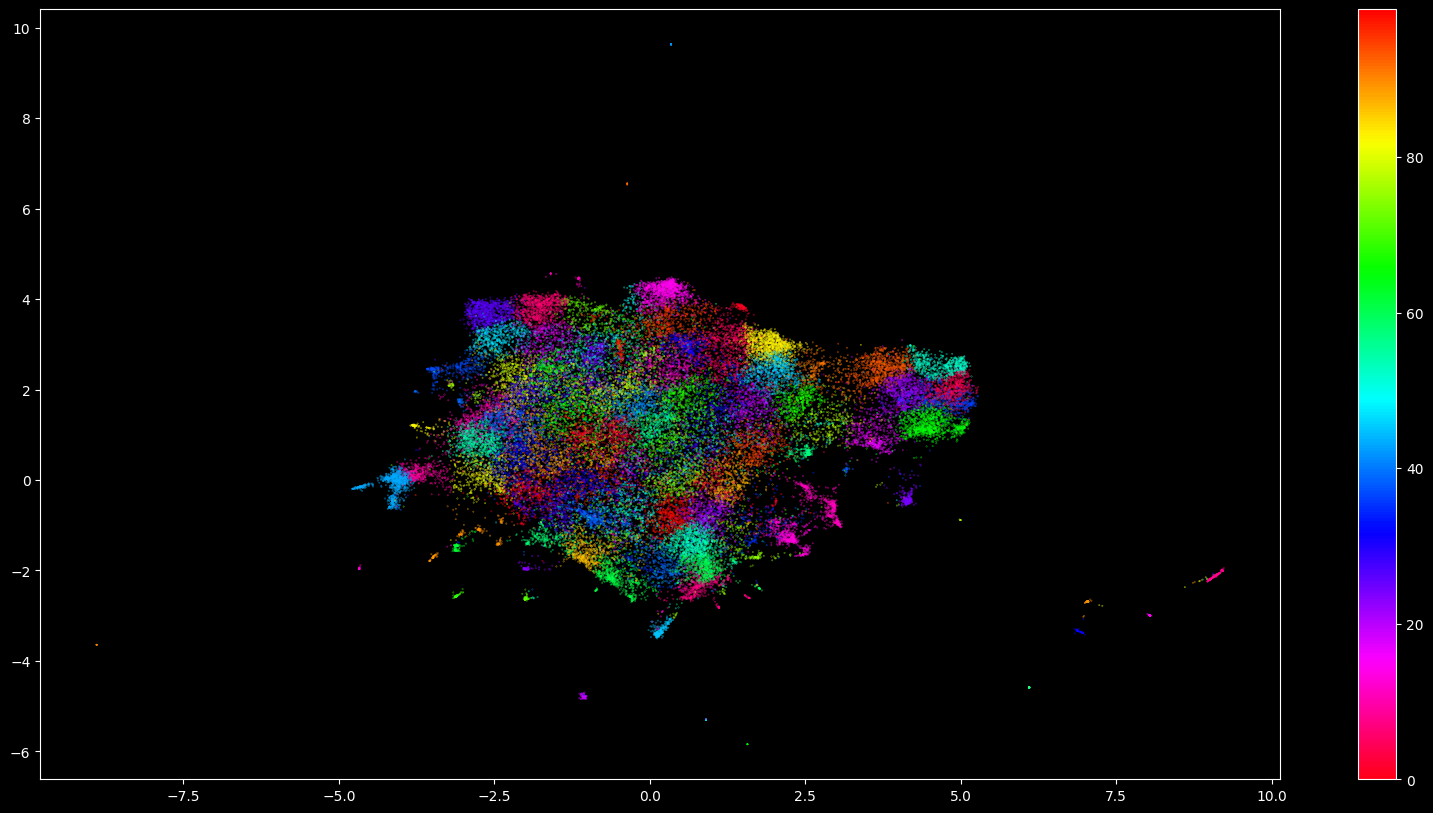

In [149]:
cl_viz(corpus_embeddings, kmeans.labels_, 'cl.png')

## USE

In [161]:
import tensorflow_hub as hub
import tensorflow_text

module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3'

model = hub.load('/Users/darapetruhnenko/Downloads/universal-sentence-encoder-multilingual_3/saved_model.pb')

def embed_text(input):
    return model(input)

OSError: SavedModel file does not exist at: /Users/darapetruhnenko/Downloads/universal-sentence-encoder-multilingual_3/saved_model.pb/{saved_model.pbtxt|saved_model.pb}

In [453]:
embedding_matrix = list(tqdm(map(embed_text, short['Text']), total=len(full)))

In [174]:
with open('/Users/darapetruhnenko/Downloads/use_emb.pickle', 'rb') as f:
    corpus_embeddings = pickle.load(f)

In [177]:
corpus_embeddings = [elem[0] for elem in corpus_embeddings]

In [178]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5,
                            min_dist=0.0,
                            metric='cosine').fit_transform(corpus_embeddings)

inertia = []
silhouette = {}
for i in tqdm(range(100,201, 25)):
    kmeans = KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(umap_embeddings)
    inertia.append(kmeans.inertia_)
    silhouette[i] = silhouette_score(umap_embeddings, kmeans.labels_, metric='euclidean')

print(silhouette)
print(inertia)


{100: 0.34186795, 125: 0.33380675, 150: 0.32692584, 175: 0.3239556, 200: 0.3205209}
[6722.8984375, 5624.92138671875, 4881.44970703125, 4326.537109375, 3930.20654296875]


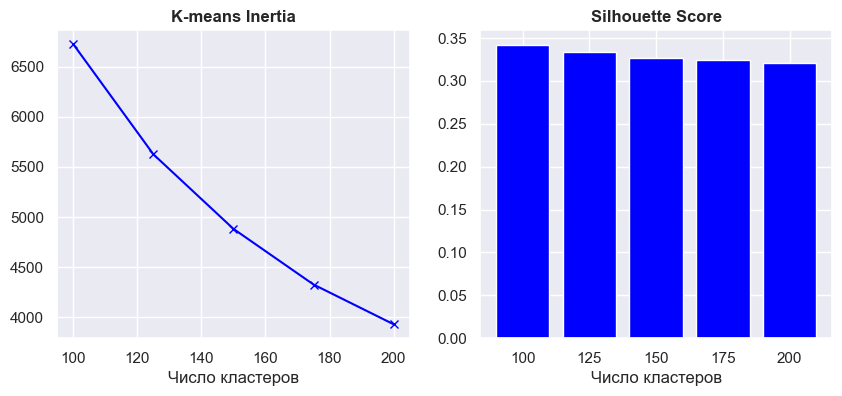

In [180]:
viz_metrics(inertia, silhouette, 100,201, 25)

In [181]:
kmeans = KMeans(n_clusters=100,
           init='k-means++',
           n_init=15,
           max_iter=500,
           random_state=17)
kmeans.fit(umap_embeddings)

KMeans(max_iter=500, n_clusters=100, n_init=15, random_state=17)

In [193]:
short['cluster'] = kmeans.labels_
short[short['cluster'] == 27]

,Unnamed: 0,Title,Text,cluster,cluster_bert
9,9,It Takes Two,embark craziest journey life take two invite f...,27,98
19,19,Fall Guys: Ultimate Knockout,fall guy massively multiplayer party player on...,27,81
32,32,Among Us,online local party teamwork betrayal player sp...,27,47
77,77,Pummel Party,pummel party player online local multiplayer p...,27,81
95,95,Overcooked! 2,overcook return brand new help chaotic cooking...,27,45
...,...,...,...,...,...
46369,46369,Candy Kombat,immerse world sweet full delicious candy beat ...,27,0
46543,46543,Deep Space Gardening,deep space gardening player work hand hand gro...,27,66
46570,46570,StellaSpella,help stella mile battle evil troll seek word h...,27,29
46576,46576,Wreckout,get ready wreck spin fling way brick bust glor...,27,10


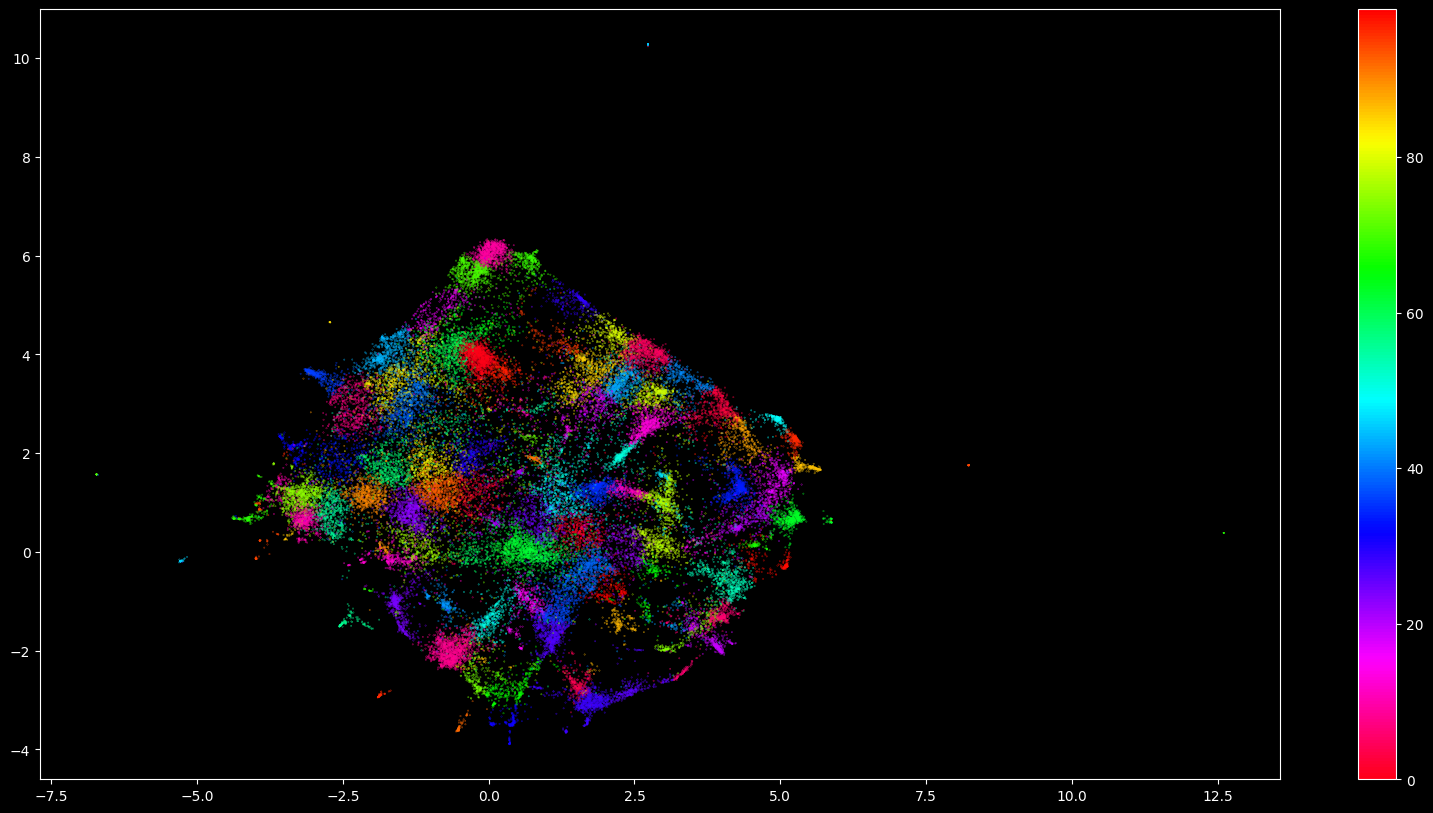

In [196]:
cl_viz(corpus_embeddings, kmeans.labels_, 'cl.png')

In [303]:
data['use_cluster'] = short['cluster']
data['bert_cluster'] = short['cluster_bert']

data['Tf-Idf cluster'] = full['Cluster_tf-idf']
data['Umap cluster'] = full['cluster_umap']

data.to_csv('rec.csv')